# All-e market research
This notebook contains the data analysis for the all-e market research.  

## contents
1) Loading daily aggregated data from Clickhouse / local.
2) Fitting a heat demand vs. ambiant temperature model per cic.
3) Fitting a water temp vs. ambiant temperature model per cic.
4) Extrapolating both to make a plot at -10, -5 and 0 degrees for each cic.
5) Plotting in the same figure the maximum available heat production.


to do:
- filter out cic's with more than 10 missing days (cic swaps?)
- check filtering of outliers, especially for water supply model
- check if we can filter out houses in a certain way
- is there a way to make sure that we are looking an accurate representation?
- is 5kWh going to make a significant impact?

In [4]:
import clickhouse_connect
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import os
from os import path
from plotly import colors
import plotly.express as px 
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pyod.models.cd import CD
from pyod.models.thresholds import FWFM
from scipy.optimize import curve_fit
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import urlparse
from requests import HTTPError
from math import radians, cos, sin, asin, sqrt
from knmy import knmy
import pgeocode
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# PLotting theme
pio.templates.default = "plotly_white"

In [5]:
# Load username and password from .env file
env_path = Path('../') / '.env'
load_dotenv(env_path)

True

## 2) data cleaning and definition of models

In [6]:
def heat_demand_model(Ta, c0, c1):
    return c0 * Ta + c1

## 1) Load daily aggregated data from clickhouse

In [7]:
# Set up Clickhouse client
HOST_CH = os.getenv("HOST_CH")
USERNAME_CH = os.getenv("USERNAME_CH")
PASSWORD_CH = os.getenv("PASSWORD_CH")
client = clickhouse_connect.get_client(host=HOST_CH, port=8443, username=USERNAME_CH, password=PASSWORD_CH)

del HOST_CH, USERNAME_CH, PASSWORD_CH


In [8]:
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = True
SAVE_LOCAL_DATA = True

i=0

filename = 'CH_data_3hr_{}.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_cics = pd.read_csv(filepath.format('all'))
else:
    sql_get_cic_ids = """
    WITH cic_ids AS (
        SELECT
            clientid,
            ifNull(max(qc_houseEnergyCounter) - min(qc_houseEnergyCounter), 0) AS Q_house
        FROM "{cic_stats_table}"
        WHERE
            time_ts >= '{start_date}'
        GROUP BY
            clientid
        ORDER BY
            Q_house DESC
        LIMIT {num_cics} OFFSET {offset}
    ),
    hourly_values AS (
        SELECT
            clientid,
            toStartOfHour(time_ts) AS h,
            avg(hp1_temperatureOutside) as ambientTemperature,
            avgIf(flowMeter_waterSupplyTemperature, 
                qc_supervisoryControlMode IN (2, 3, 4)
            ) as supplyTemperature,
            avgIf(greatest(
                    coalesce(hp1_watchdogCode=9,0),
                    coalesce(hp2_watchdogCode=9,0)
                ), 
                qc_supervisoryControlMode IN (2,3,4)
            ) as supplyTemperatureOos,
            avg(thermostat_otFtRoomSetpoint - thermostat_otFtRoomTemperature) as roomTemperatureError,
            avg(thermostat_otFtRoomSetpoint) as roomSetTemperature,
            avg(thermostat_otFtRoomTemperature) as roomTemperature,
            ifNull(argMax(hp1_thermalEnergyCounter, time_ts) - argMin(hp1_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp1,
            ifNull(argMax(hp2_thermalEnergyCounter, time_ts) - argMin(hp2_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp2,
            ifNull(argMax(hp1_electricalEnergyCounter, time_ts) - argMin(hp1_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp1,
            ifNull(argMax(hp2_electricalEnergyCounter, time_ts) - argMin(hp2_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp2,
            Q_hp1 + Q_hp2 AS Q_hp,
            E_hp1 + E_hp2 AS E_hp,
            ifNull(argMax(qc_cvEnergyCounter, time_ts) - argMin(qc_cvEnergyCounter, time_ts), 0)/1000 AS Q_cv,
            Q_hp + Q_cv AS Q_house,
            (({cost_gas} / {calorific_value_gas} * (Q_hp)) - ({cost_electricity} * (E_hp))) AS savings,
            SUM(Q_hp) OVER w_3hr AS Q_hp_3hr,
            SUM(Q_hp1) OVER w_3hr AS Q_hp1_3hr,
            SUM(Q_hp2) OVER w_3hr AS Q_hp2_3hr,
            SUM(E_hp) OVER w_3hr AS E_hp_3hr,
            SUM(E_hp1) OVER w_3hr AS E_hp1_3hr,
            SUM(E_hp2) OVER w_3hr AS E_hp2_3hr,
            SUM(Q_cv) OVER w_3hr AS Q_cv_3hr,
            SUM(Q_house) OVER w_3hr AS Q_house_3hr,
            Q_hp_3hr / Q_house_3hr as hpHeatRatio_3hr,
            Q_hp_3hr / E_hp_3hr as COP_3hr,
            AVG(supplyTemperature) OVER w_3hr AS supplyTemperature_3hr
        FROM
            "{cic_stats_table}"
        WHERE clientid IN (SELECT clientid FROM cic_ids)
            AND time_ts >= '{start_date}'
        GROUP BY
            clientid,
            h
        WINDOW w_3hr AS (
            PARTITION BY clientid
            ORDER BY h
            ROWS BETWEEN CURRENT ROW AND 2 FOLLOWING
        )
        ORDER BY
            clientid,
            h
    )
    SELECT clientid, toDate(h) as d, 
        avg(ambientTemperature) as ambientTemperature,
        avg(supplyTemperature) as supplyTemperature,
        avg(supplyTemperatureOos) as supplyTemperatureOos,
        avg(roomTemperatureError) as roomTemperatureError,
        avg(roomSetTemperature) as roomSetTemperature,
        avg(roomTemperature) as roomTemperature,
        sum(Q_hp) as Q_hp_24hr,
        sum(Q_hp1) as Q_hp1_24hr,
        sum(Q_hp2) as Q_hp2_24hr,
        sum(E_hp) as E_hp_24hr,
        sum(E_hp1) as E_hp1_24hr,
        sum(E_hp2) as E_hp2_24hr,
        sum(Q_cv) as Q_cv_24hr,
        sum(Q_house) as Q_house_24hr,
        Q_hp_24hr / Q_house_24hr as hpHeatRatio,
        Q_hp_24hr / E_hp_24hr as COP,
        argMax(h, Q_house_3hr) as h_3hr_max,
        max(Q_house_3hr) as Q_house_3hr_max,
        argMax(Q_hp_3hr, Q_house_3hr) as Q_hp_3hr_max,
        argMax(Q_hp1_3hr, Q_house_3hr) as Q_hp1_3hr_max,
        argMax(Q_hp2_3hr, Q_house_3hr) as Q_hp2_3hr_max,
        argMax(E_hp_3hr, Q_house_3hr) as E_hp_3hr_max,
        argMax(E_hp1_3hr, Q_house_3hr) as E_hp1_3hr_max,
        argMax(E_hp2_3hr, Q_house_3hr) as E_hp2_3hr_max,
        argMax(Q_cv_3hr, Q_house_3hr) as Q_cv_3hr_max,
        argMax(hpHeatRatio_3hr, Q_house_3hr) as hpHeatRatio_3hr_max,
        argMax(COP_3hr, Q_house_3hr) as COP_3hr_max,
        argMax(supplyTemperature_3hr, Q_house_3hr) as supplyTemperature_3hr_max
    FROM hourly_values
    GROUP BY clientid, toDate(h)
    HAVING Q_house_24hr > 3
    ORDER BY clientid, toDate(h)
    """

    # retrieve data in batches to avoid server side memory issues
    for i in range(0, 5):
        query_result = client.query_df(
            sql_get_cic_ids.format(
                        num_cics = 1000,
                        offset = i*1000,
                        start_date = '2023-08-01',
                        cic_stats_table = 'cic_stats',
                        calorific_value_gas = 8.8, # kWh/m3
                        cost_gas = 1.46, # €/m3
                        cost_electricity = 0.36 # €/kWh
            )
        )
        query_result.to_csv(filepath.format(i), index=False)
    
    # concatenate
    for i in range(0,5):
        block = pd.read_csv(filepath.format(i))
        if i==0:
            df_cics = block.copy()
        else:
            df_cics = pd.concat([df_cics, block])
    df_cics.to_csv(filepath.format('all'), index=False)



In [10]:
# get number of heat pumps per cic_id
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = False
SAVE_LOCAL_DATA = True

filename = 'CH_nhps.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_nhps = filepath
else:
    sql_get_nhps = """
    SELECT
        clientid,
        max(coalesce(system_ccNumberOfHeatPumps, 0)) as nhps
    FROM cic_stats
    WHERE time_ts > '2023-08-01'
    GROUP BY clientid
    order by nhps
    """

    df_nhps = client.query_df(sql_get_nhps)
    if SAVE_LOCAL_DATA:
        df_nhps.to_csv(filepath, index=False)



In [11]:
# Clean up and pre-process data

# rename clientid to cic_id
df_cics.rename(columns={'clientid': 'cic_id'}, inplace=True)
df_cics['dt'] = pd.to_datetime(df_cics['d'])

print(f"Number of CiCs: {len(df_cics['cic_id'].unique())}")
print(f"Number of rows: {len(df_cics.index)}")

# Remove outliers from Q_hp1, Q_hp2, E_hp1, E_hp2
max_Q_hp = 8 # kWh
max_E_hp = 3 # kWh
max_Q_cv = 37 # kWh

df_cics = df_cics[
    (df_cics['Q_hp1_24hr'] < 24 * max_Q_hp) & (df_cics['Q_hp2_24hr'] < 24 * max_Q_hp) & 
    (df_cics['E_hp1_24hr'] < 24 * max_E_hp) & (df_cics['E_hp2_24hr'] < 24 * max_E_hp) &
    (df_cics['Q_cv_24hr'] < 24 * max_Q_cv)
].copy()
print(f"Number of rows after removing 24hr outliers: {len(df_cics.index)}")

df_cics = df_cics[
    (df_cics['Q_hp1_3hr_max'] < 3 * max_Q_hp) & (df_cics['Q_hp2_3hr_max'] < 3 * max_Q_hp) & 
    (df_cics['E_hp1_3hr_max'] < 3 * max_E_hp) & (df_cics['E_hp2_3hr_max'] < 3 * max_E_hp) &
    (df_cics['Q_cv_3hr_max'] < 3 * max_Q_cv)
].copy()
print(f"Number of rows after removing 3hr outliers: {len(df_cics.index)}")

# Remove days when CiC was in LTE mode
df_cics.dropna(subset=['ambientTemperature', 'supplyTemperature', 'roomTemperatureError', 'roomSetTemperature', 'roomTemperature'], inplace=True)
print(f"Number of rows after removing days when CiC was in LTE mode: {len(df_cics.index)}")

# remove rows with extremely low temperature measurement
df_cics = df_cics[df_cics['ambientTemperature']>-5]
print(f"Number of rows after removing rows when ambientTemperature < -5: {len(df_cics.index)}")

# Remove rows of cic's that have less than 10 days of data
df_cics = df_cics.groupby('cic_id').filter(lambda x: len(x.index) >= 10)
print(f"Number of rows after removing cic's with less than 10 days of data: {len(df_cics.index)}")

# Remove rows of cic's that have data only after 2023-11-23
df_cics = df_cics.groupby('cic_id').filter(lambda x: min(x.dt) <= pd.to_datetime('2023-11-26'))
print(f"Number of rows after removing cic's with no data before 2023-11-26: {len(df_cics.index)}")
print(f"Number of cics: {len(df_cics['cic_id'].unique())}")



Number of CiCs: 4852
Number of rows: 353038
Number of rows after removing 24hr outliers: 351197
Number of rows after removing 3hr outliers: 348817
Number of rows after removing days when CiC was in LTE mode: 335006
Number of rows after removing rows when ambientTemperature < -5: 334887
Number of rows after removing cic's with less than 10 days of data: 334654
Number of rows after removing cic's with no data before 2023-11-26: 322787
Number of cics: 4311


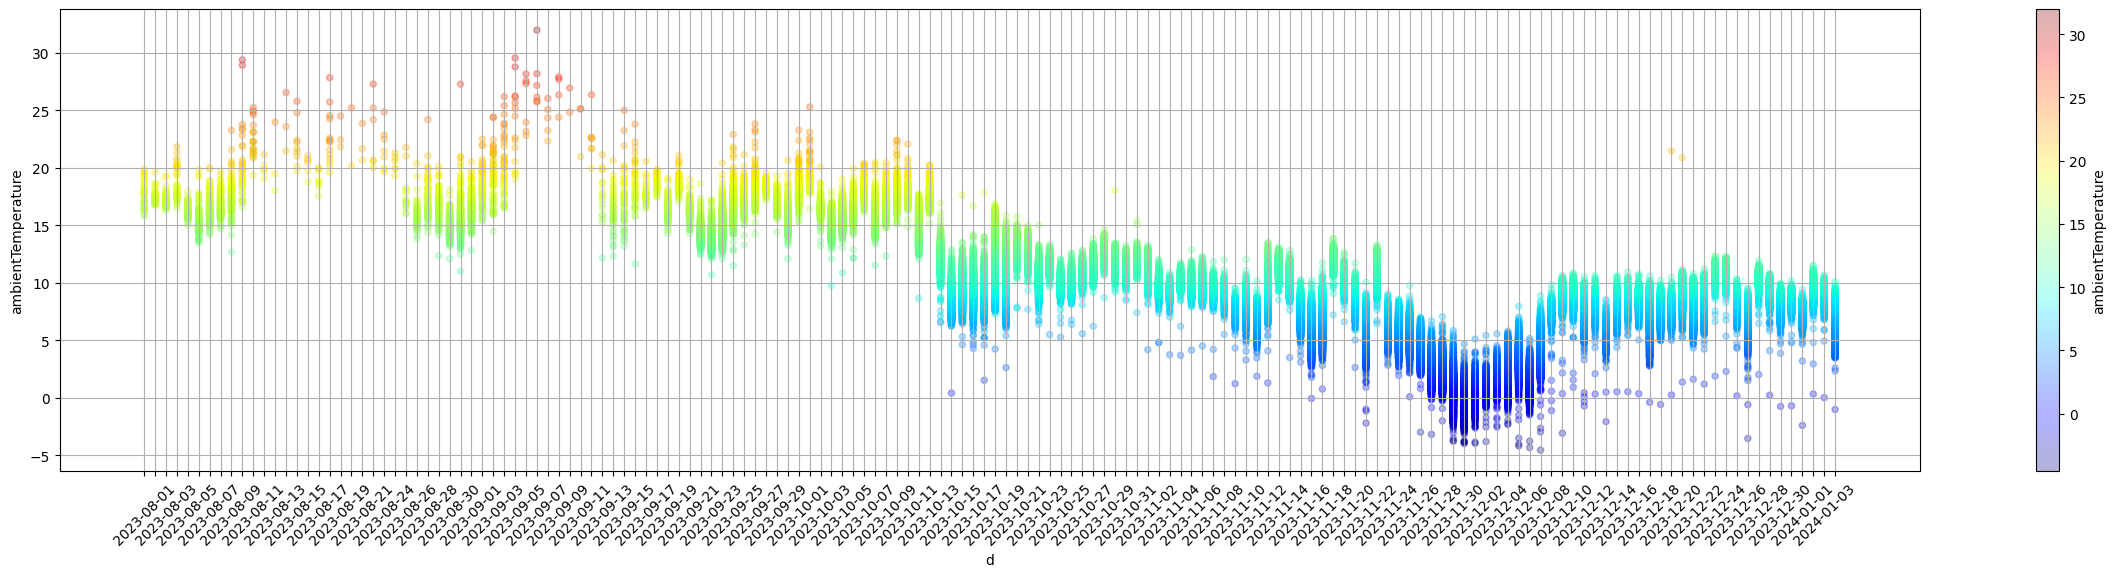

In [12]:
# df_cics['dm'] = df_cics['d'].dt.strftime('%m-%d')
df_cics.sort_values(by='d', inplace=True)
ax = df_cics.plot(kind='scatter', y='ambientTemperature', x='d', figsize=[30, 6], c='ambientTemperature', cmap='jet', rot=45, alpha=0.3, grid=True)

# Customizing to show every other label
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    if i % 2 != 0:  # Hide every other label
        label.set_visible(False)

plt.show()

In [13]:
# Mark outliers for determining heat demand curve and supply temperature curve

# per cic mark water outliers and 
# df_cics['water_outlier'] = 0
# df_cics['heat_outlier'] = 0

# # errors during outlier detection
# errors = []


# for cic in df_cics['cic_id'].unique():
#     df_cic = df_cics[df_cics['cic_id'] == cic]

#     try: 
#         X = df_cic[['Q_hp', 'Q_house']].to_numpy()
#         model = CD(contamination=FWFM())
#         model.fit(X)
#         y_pred = model.predict(X)
#         # set y-pred back into original df
#         df_cics.loc[df_cics['cic_id'] == cic,'heat_outlier'] = y_pred
#     except ValueError:
#         errors.append(cic)
#         pass
    
    # try: 
    #     X = df_cic[['ambientTemperature', 'supplyTemperature']].to_numpy()
    #     model = CD(contamination=FWFM())
    #     model.fit(X)
    #     y_pred = model.predict(X)
    #     df_cics.loc[df_cics['cic_id'] == cic,'water_outlier'] = y_pred
    # except ValueError:
    #     pass

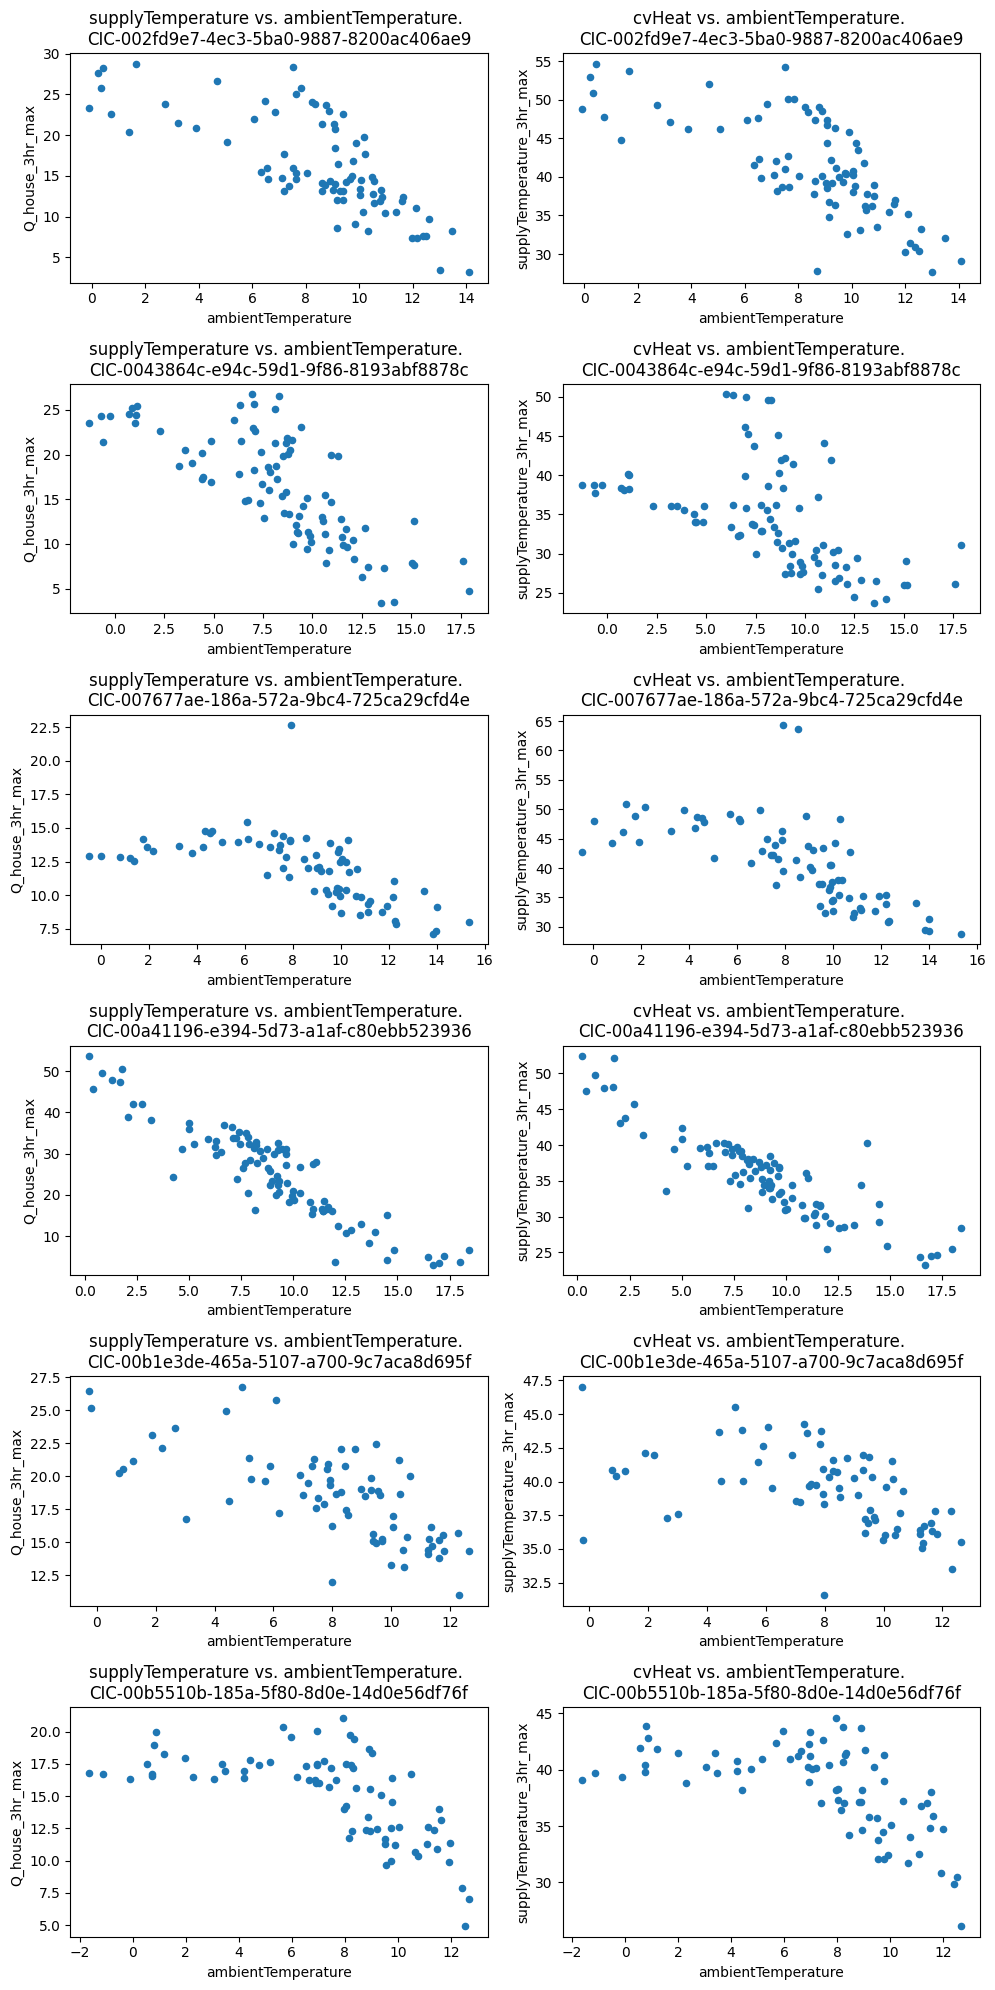

In [287]:
# plot supplyTemperature vs. ambientTemperature for several cic's
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cics[i+6]]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='Q_house_3hr_max', 
                # c='heat_outlier', cmap='jet', 
                ax=axs[i*2], label=cic)
    axs[i*2].set_title(f'supplyTemperature vs. ambientTemperature. \n{cic}')
    axs[i*2].get_legend().remove()

    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max', 
                 ax=axs[i*2+1], label=cic)
    axs[i*2+1].set_title(f'cvHeat vs. ambientTemperature. \n{cic}')
    axs[i*2+1].get_legend().remove()
    # axs[i].collections[0].colorbar.remove()


plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



# fig = go.Figure()
# for cic in cics[:5]:
#     df_cic = df_cics[df_cics['cic_id'] == cic]
#     fig.add_trace(go.Scatter(x=df_cic['ambientTemperature'], y=df_cic['supplyTemperature'], mode='markers', name=cic))
# fig.update_layout(title='supplyTemperature vs. ambientTemperature for several cic\'s')
# fig.show()

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465185769.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic['residuals'] = abs(df_cic['supplyTemperature_3hr_max'] - model.predict(df_cic[['ambientTemperature']]))
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465185769.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic['residuals_rel'] = df_cic['residuals'] / df_cic['residuals'].std()
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465

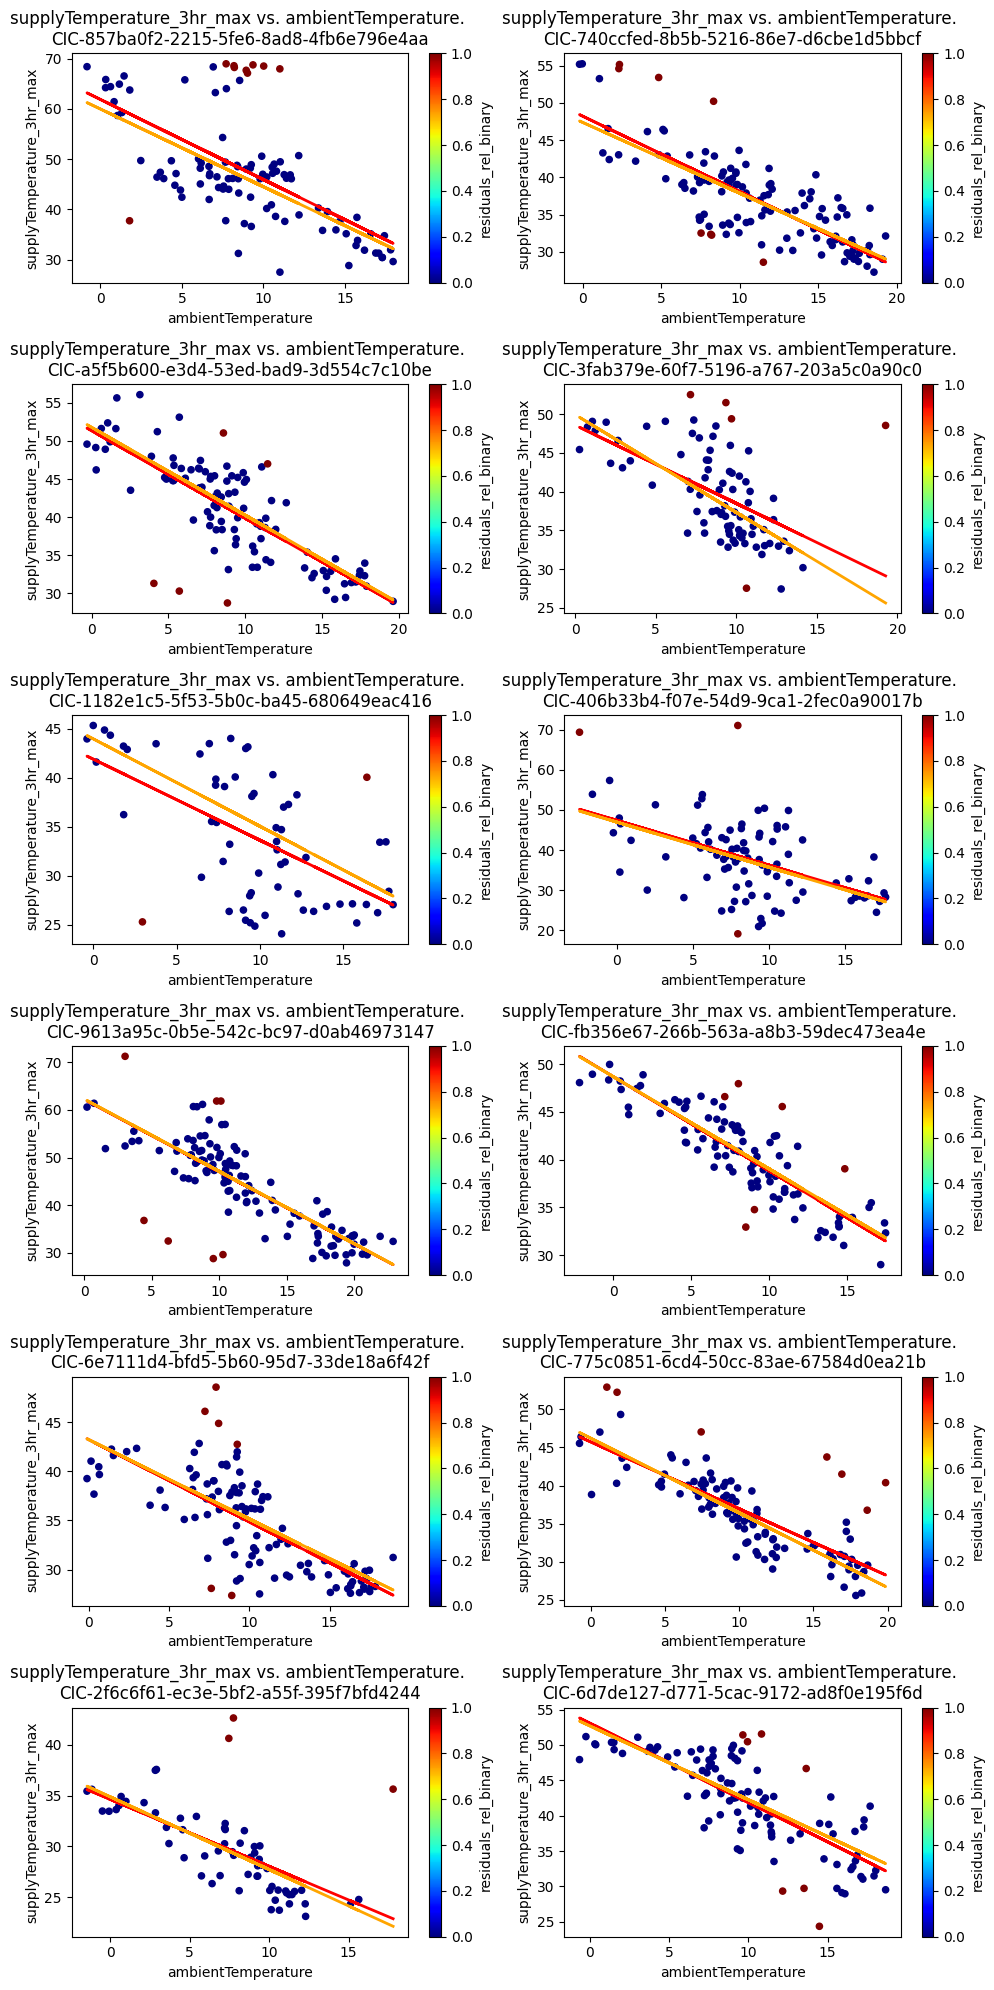

In [117]:
cics = df_cics['cic_id'].unique()
model = LinearRegression()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:12]):  # Change the slice to select the first 6 cics
    i+12
    df_cic = df_cics[df_cics['cic_id'] == cic]


    model.fit(df_cic[['ambientTemperature']], df_cic['supplyTemperature_3hr_max'])
    # absoluate error
    df_cic['residuals'] = abs(df_cic['supplyTemperature_3hr_max'] - model.predict(df_cic[['ambientTemperature']]))
    df_cic['residuals_rel'] = df_cic['residuals'] / df_cic['residuals'].std()
    df_cic['residuals_rel_binary'] = np.where(df_cic['residuals_rel'] > 3, 1, 0)
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max',
                c='residuals_rel_binary', cmap='jet', ax=axs[i], label=cic)
    
    # plot linear regression line
    axs[i].plot(df_cic['ambientTemperature'], model.predict(df_cic[['ambientTemperature']]), color='red', linewidth=2)

    TSModel = TheilSenRegressor(random_state=0).fit(df_cic[['ambientTemperature']], df_cic['supplyTemperature_3hr_max'])
    axs[i].plot(df_cic['ambientTemperature'], TSModel.predict(df_cic[['ambientTemperature']]), color='orange', linewidth=2)

    if TSModel.coef_ > 0:
        axs[i].axhline(y=df_cic['supplyTemperature_3hr_max'].quantile(0.8), color='green', linestyle='--')

    axs[i].set_title(f'supplyTemperature_3hr_max vs. ambientTemperature. \n{cic}')
    axs[i].get_legend().remove()
    # axs[i].collections[0].colorbar.remove()


plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()


In [60]:
import random

In [15]:
def fit_model(df, x_col, y_col):
    model = TheilSenRegressor(random_state=0)
    
    if len(df.index) >= 10:
        X = df[x_col].to_numpy().reshape(-1, 1)
        y = df[y_col].to_numpy()
        model.fit(X, y)
        rmse = mean_squared_error(y, model.predict(X), squared=False)
        score = model.score(X, y)
        
        return model.coef_[0], model.intercept_, rmse, len(df), score
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan



# Define the cic_ids and column pairs
cic_ids = df_cics['cic_id'].unique()
# cic_ids = random.sample(df_cics['cic_id'].unique().tolist(), 1000)
# take a random sample of 100 cic's out of cic_ids

model_list = [{'colname': 'supplyTemperature', 'name':'WaterTemp_24hr'},
              {'colname': 'Q_house_24hr', 'name':'Q_house_24hr'},
            #   {'colname': 'supplyTemperature_3hr_max', 'name':'WaterTemp_3hr_filt', 'filter':'ambientTemperature<7'},
              {'colname': 'supplyTemperature_3hr_max', 'name':'WaterTemp_3hr'},
              {'colname': 'Q_house_3hr_max', 'name':'Q_house_3hr'}]

metrics = ['slope', 'intercept', 'rmse', 'n', 'R2']

# create dataframe for models
df_cic_models_columns = ['cic_id'] + [f'{model["name"]}_{metric}' for model in model_list for metric in metrics]
df_cic_models = pd.DataFrame(columns=df_cic_models_columns)
df_cic_models['cic_id'] = cic_ids

# create dataframe for results
df_results = pd.DataFrame(columns=['cic_id',*[model['name'] for model in model_list]])
df_results['cic_id'] = cic_ids


# train models
for cic in cic_ids:
    df_cic = df_cics[df_cics['cic_id']==cic]

    for model in model_list:
        if 'filter' in model:
            slope, intercept, rmse, n, score = fit_model(df_cic.query(model['filter']),
                                                  'ambientTemperature',
                                                  model['colname'])
        else:
            slope, intercept, rmse, n, score = fit_model(df_cic,
                                                  'ambientTemperature', 
                                                  model['colname'])

        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_slope'] = slope
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_intercept'] = intercept
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_rmse'] = rmse
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_n'] = n
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_R2'] = score

In [17]:
df_cic_models = df_cic_models.apply(pd.to_numeric, errors='ignore')

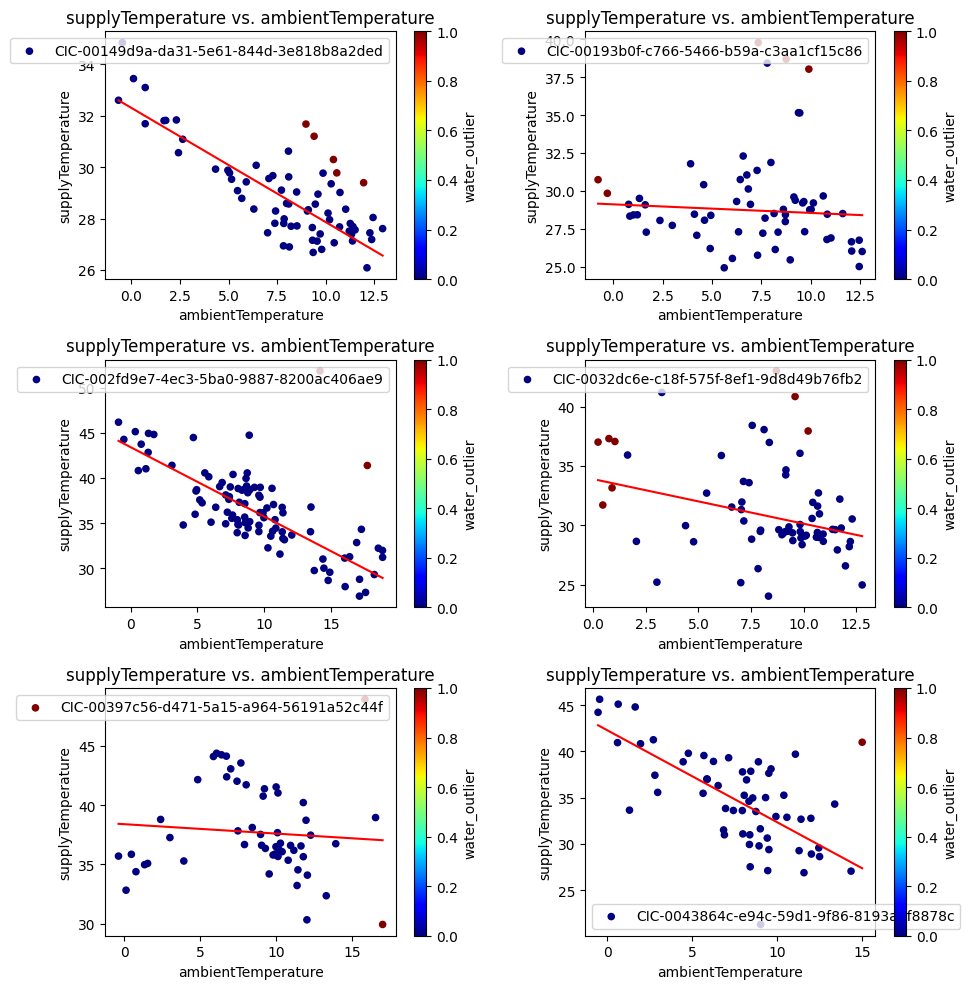

In [112]:
# plot supplyTemperature vs. ambientTemperature for several cic's using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature', 
                c='water_outlier', cmap='jet', ax=axs[i], label=cic)
    axs[i].set_title(f'supplyTemperature vs. ambientTemperature')
    # axs[i].set_suptitle(cic)
    axs[i].legend()
    # add line based on linear regression model
    x = np.linspace(df_cic['ambientTemperature'].min(), df_cic['ambientTemperature'].max(), 100)
    y = df_cics_train[df_cics_train['cic_id'] == cic]['water_slope'].values[0] * x + df_cics_train[df_cics_train['cic_id'] == cic]['water_intercept'].values[0]
    axs[i].plot(x, y, '-r')

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



## Extrapolate to -7 degrees

From [google sheet](https://docs.google.com/spreadsheets/d/15kTyQeI37S-ABCxKRoklAmAvpKCPe6Ss/edit#gid=177825386).  
At -7 degrees, for a 4kW unit:  
- supplyTemperature = 35, Pmax = 4.748 (90 Hz), Qmax = 113.952
- supplyTemperature = 45, Pmax = 3.627 (90 Hz), Qmax = 87.048
- supplyTemperature = 55, Pmax = 3.360 (84 Hz), Qmax = 80.64
- electricalHeater of boiler of 2kW -> Qmax += 48

At -7 degrees, for an 8kW unit:
- supplyTemperature = 35, Pmax = 8.375 = 3.980 + 4.748 (79 Hz & 90 Hz), Qmax = 201
- supplyTemperature = 45, Pmax = 6.739 = 3.11 + 3.627 (79Hz & 90 Hz), Qmax = 161.75
- supplyTemperature = 55, Pmax = 6.40 = 3.04 * 3.360 (79Hz & 84 Hz), Qmax = 153.62
- electricalHeater of boiler of 2kW -> Qmax += 48


single_hybrid_limits = [4.748, 3.627, 3.360]
double_hybrid_limits = [8.375, 6.739, 6.40]

In [28]:
# calculate heat demand and water supply temperature for each cic
target_temperature = -7

df_results = pd.DataFrame(columns=['cic_id',*[model['name'] for model in model_list]])
df_results['cic_id'] = cic_ids

# only cic's where heat demand goes up as temperature goes down
# df_results['cic_id'] = df_cics_train[(df_cics_train['heat_slope']<0) & (df_cics_train['water_slope'].notna())]['cic_id'].unique()

# predict target temperature
for model in model_list:
    df_results[model['name']] = df_results['cic_id'].apply(
        lambda x: heat_demand_model(target_temperature,
                                    df_cic_models[df_cic_models['cic_id'] == x][f'{model["name"]}_slope'].values[0],
                                    df_cic_models[df_cic_models['cic_id'] == x][f'{model["name"]}_intercept'].values[0]))

df_merged = pd.merge(df_results, df_cic_models, on='cic_id', how='left')

In [32]:
df_mean_std = df_cics.groupby('cic_id')['supplyTemperature_3hr_max'].mean() + 2 * df_cics.groupby('cic_id')['supplyTemperature_3hr_max'].std()

df_merged = df_merged.merge(df_mean_std, on='cic_id', how='left')

array([[<Axes: title={'center': 'WaterTemp_3hr'}>,
        <Axes: title={'center': 'supplyTemperature_3hr_max'}>]],
      dtype=object)

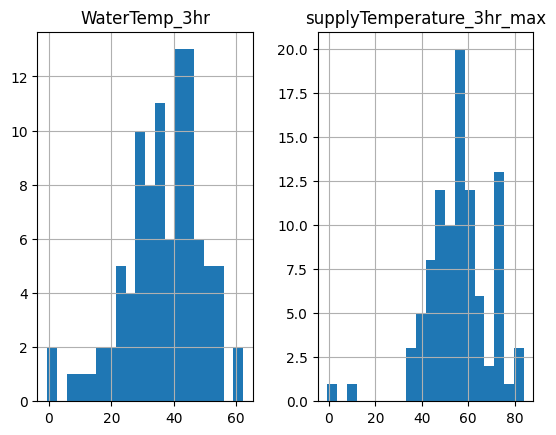

In [38]:
# replace linear models with negative slope with their mean + 2*std (for watersupplyTemperature 3hr)

df_merged[df_merged['WaterTemp_3hr_slope']>0][['WaterTemp_3hr','supplyTemperature_3hr_max']].hist(bins=20)

In [39]:
# replace linear models with negative slope with their mean + 2*std (for watersupplyTemperature 3hr)
df_merged.loc[df_merged['WaterTemp_3hr_slope']>0, 'WaterTemp_3hr'] = df_merged.loc[df_merged['WaterTemp_3hr_slope']>0, 'supplyTemperature_3hr_max']

In [40]:
# heat pump limits at -7 degrees ambiant
lwt = limit_water_temps =    [20,     35,      45,      55] # deg. Celcius
shl = single_hybrid_limits = [4.748,  4.748,   3.627,   3.360] #kW
hdl = hybrid_duo_limits =    [8.375,  8.375,   6.739,   6.40] #kW

boost = 2.5 #kW
electric_element = 2 #kW

# single including boost
shl_wb = [x + boost for x in shl]
shl_wb_we = [x + boost + electric_element for x in shl]
shl_we = [x + electric_element for x in shl]

# hybrid duo including boost and element
hdl_wb =[x + boost for x in hdl]
hdl_wb_we = [x + boost + electric_element for x in hdl]
hdl_we = [x + electric_element for x in hdl]

def make_polygon(pol):
    pol['x'] = [*pol['lwt'], *pol['lwt'][::-1]]
    pol['y'] = [x * pol['hrs'] for x in [*pol['upper_bound'], *pol['lower_bound'][::-1]]]

    return pol

# create a function that checks whether a point is inside a polygon
def point_in_polygon(point, polygon):
    return Polygon(polygon).contains_point(point)

# define plotting function
def plot_results(df_results, polygons, title, xcol, ycol, shortname):
    
    # attach color and id to df_results
    df_results[f'{shortname}_colors'] = df_results.apply(
        lambda row: next((polygon['color'] for polygon in polygons 
                          if point_in_polygon((row[xcol], row[ycol]), 
                                              list(zip(polygon['x'], polygon['y'])))), 
                                              None), axis=1)
    df_results[f'{shortname}_id'] = df_results.apply(
        lambda row: next((polygon['id'] for polygon in polygons 
                          if point_in_polygon((row[xcol], row[ycol]), 
                                              list(zip(polygon['x'], polygon['y'])))), 
                                              None), axis=1)
    
    df_results[df_results[f'{shortname}_colors'].notna()].plot(
        kind='scatter', x=xcol, y=ycol, 
        alpha=0.2, 
        c=df_results[df_results[f'{shortname}_colors'].notna()][f'{shortname}_colors'].tolist(),
        # c = df_results[df_results[f'{shortname}_colors'].notna()]['WaterTemp_3hr_R2'], cmap='jet',
        figsize=(10, 6)
    )

    for polygon in polygons:
        points_in_polygon = df_results.apply(
            lambda row: point_in_polygon((row[xcol], row[ycol]), list(zip(polygon['x'], polygon['y']))), axis=1)
        percentage = points_in_polygon.sum() / len(df_results) * 100
        if polygon['id']==12:
            labelx = 65
        else:
            labelx = sum(polygon['x'])/len(polygon['x'])
        if polygon['id']==11 or polygon['id']==12:
            labely = 15 * polygons[0]['hrs']
        else:
            labely = sum(polygon['y'])/len(polygon['y'])

        plt.text(labelx, 
                 labely, 
                 f'{polygon["label"]}: {percentage:.1f}%', 
                 horizontalalignment='center', 
                 verticalalignment='center')

    # lines seperating different polygons
    plt.axvline(x=55, color='grey', label='55 degrees',linewidth=1)

    plt.plot(polygons[0]['x'][:4], polygons[0]['y'][:4], color=polygons[0]['color'], 
             linestyle='--', label=polygons[0]['label'])
    plt.plot(polygons[1]['x'][:4], polygons[1]['y'][:4], color=polygons[1]['color'], 
             linestyle='--', label=polygons[1]['label'])
    plt.plot(polygons[2]['x'][:4], polygons[2]['y'][:4], color=polygons[2]['color'], 
             linestyle='--', label=polygons[2]['label'])


    plt.title(title)
    plt.xlabel('Supply temperature')
    plt.xlim(20, 80)
    plt.ylim(0, 20*polygons[0]['hrs'])
    plt.ylabel('Heat demand')
    # plt.grid()


    ax = plt.gca()
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    ax.spines[['bottom','left','right','top']].set_color('grey')

    # add legend
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

    # plot vertical line at 55 degrees in grey
    plt.axvline(x=55, color='grey')

    plt.show()

    return df_results





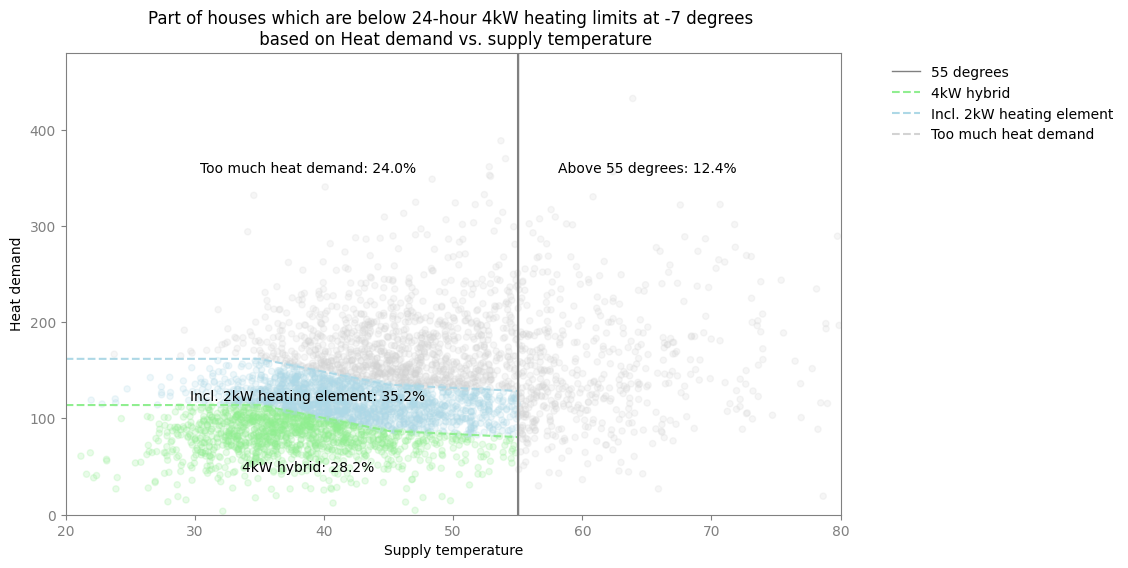

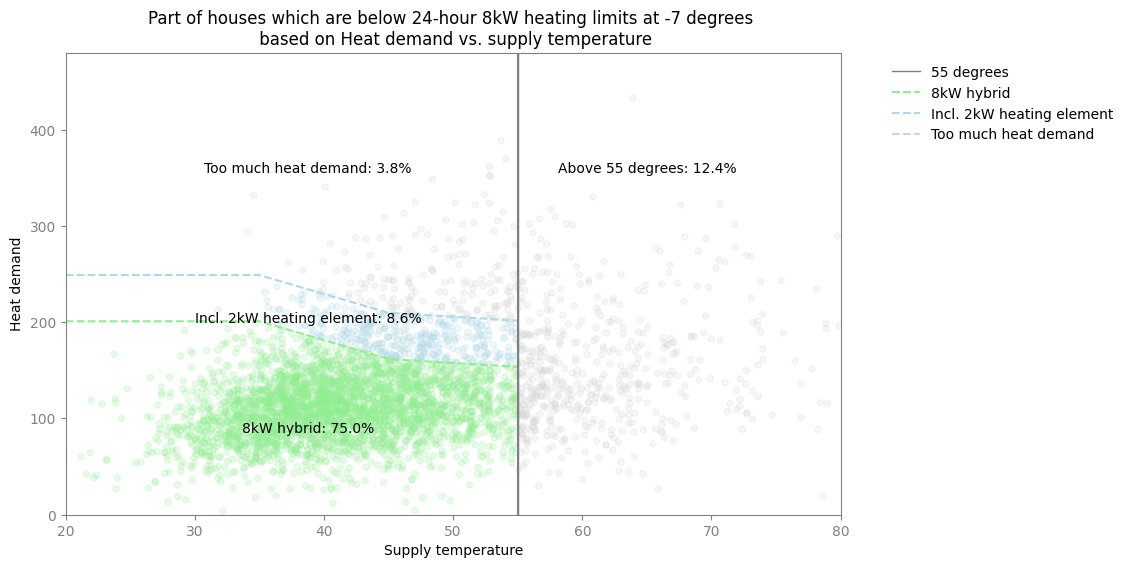

In [57]:
# 24hr hybrid single plot
hrs = 24

polygons_24_hr_single = [
    {'label': '4kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 24,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': shl},
    {'label': 'Incl. 2kW heating element', 'color': 'lightblue', 'id': 2,'hrs': 24,
     'lwt':lwt, 'lower_bound': shl, 'upper_bound': shl_we},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':24,
     'lwt':lwt, 'lower_bound': shl_we, 'upper_bound': [200, 200, 200, 200]}
]
for pol in polygons_24_hr_single:
    pol = make_polygon(pol)
polygons_24_hr_single.append({'label': 'Above 55 degrees', 'color': 'lightgrey','x':[55, 55, 200, 200], 'y': [0, 1000, 1000, 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_24_hr_single, 
                          'Part of houses which are below 24-hour 4kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_24hr', 'Q_house_24hr', '24single')

# 24hr hybrid duo plot
# set up polygons
polygons_24_hr_duo = [
    {'label': '8kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 24,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': hdl},
    {'label': 'Incl. 2kW heating element', 'color': 'lightblue', 'id': 2,'hrs': 24,
     'lwt':lwt, 'lower_bound': hdl, 'upper_bound': hdl_we},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':24,
     'lwt':lwt, 'lower_bound': hdl_we, 'upper_bound': [200, 200, 200, 200]}
]
for pol in polygons_24_hr_duo:
    pol = make_polygon(pol)
polygons_24_hr_duo.append({'label': 'Above 55 degrees', 'color': 'lightgrey','x':[55, 55, 200, 200], 'y': [0, 1000, 1000, 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_24_hr_duo, 
                          'Part of houses which are below 24-hour 8kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_24hr', 'Q_house_24hr', '24duo')

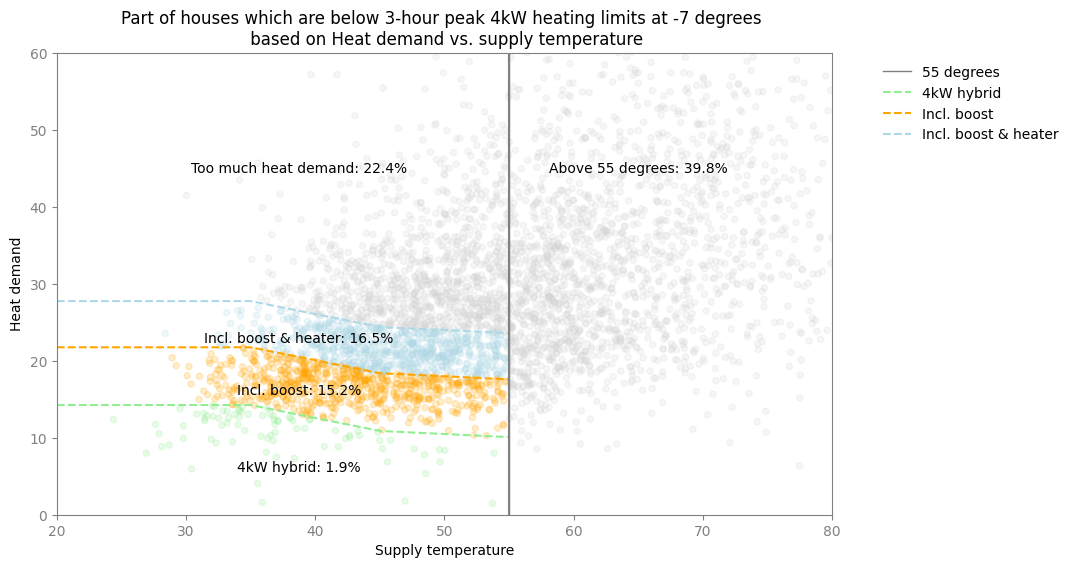

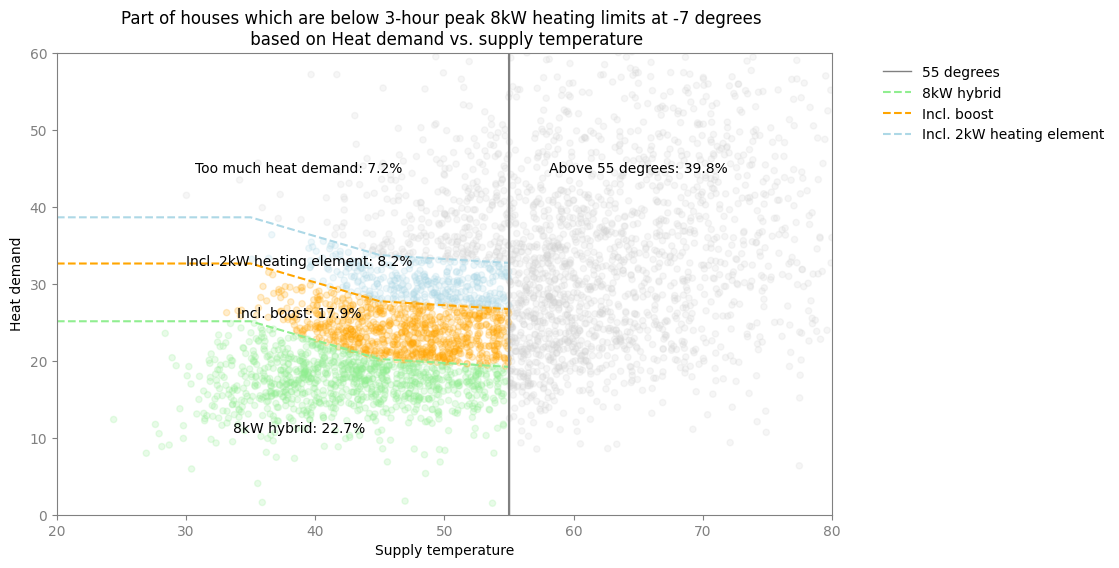

In [42]:
# 24hr hybrid single plot
hrs = 3

polygons_3_hr_single = [
    {'label': '4kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 3,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': shl},
    {'label': 'Incl. boost', 'color': 'orange', 'id': 3, 'hrs': 3,
     'lwt':lwt, 'lower_bound': shl, 'upper_bound': shl_wb},
    {'label': 'Incl. boost & heater', 'color': 'lightblue', 'id': 4,'hrs': 3,
     'lwt':lwt, 'lower_bound': shl_wb, 'upper_bound': shl_wb_we},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':3,
     'lwt':lwt, 'lower_bound': shl_wb_we, 'upper_bound': [20, 20, 20, 20]}
]
for pol in polygons_3_hr_single:
    pol = make_polygon(pol)
polygons_3_hr_single.append({'label': 'Above 55 degrees', 'color': 'lightgrey','x':[55, 55, 80, 80], 'y': [0, 100, 100, 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_3_hr_single, 
                          'Part of houses which are below 3-hour peak 4kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_3hr', 'Q_house_3hr', '3single')

# 24hr hybrid duo plot
# set up polygons
polygons_3_hr_duo = [
    {'label': '8kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 3,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': hdl},
     {'label': 'Incl. boost', 'color': 'orange', 'id': 3, 'hrs': 3,
     'lwt':lwt, 'lower_bound': hdl, 'upper_bound': hdl_wb},
    {'label': 'Incl. 2kW heating element', 'color': 'lightblue', 'id': 4,'hrs': 3,
     'lwt':lwt, 'lower_bound': hdl_wb, 'upper_bound': hdl_wb_we},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':3,
     'lwt':lwt, 'lower_bound': hdl_wb_we, 'upper_bound': [20, 20, 20, 20]}
]
for pol in polygons_3_hr_duo:
    pol = make_polygon(pol)
polygons_3_hr_duo.append({'label': 'Above 55 degrees', 'color': 'lightgrey','x':[55, 55, 80, 80], 'y': [0, 100, 100, 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_3_hr_duo, 
                          'Part of houses which are below 3-hour peak 8kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_3hr', 'Q_house_3hr', '3duo')

## sankey diagram

In [49]:
# merge number of heat pumps onto df_merged
df_merged = df_merged.merge(query_result, left_on='cic_id', right_on='clientid', how='left')

In [54]:
df_merged

,cic_id,WaterTemp_24hr,Q_house_24hr,WaterTemp_3hr,Q_house_3hr,WaterTemp_24hr_slope,WaterTemp_24hr_intercept,WaterTemp_24hr_rmse,WaterTemp_24hr_n,WaterTemp_24hr_R2,...,Q_house_3hr_rmse,Q_house_3hr_n,Q_house_3hr_R2,supplyTemperature_3hr_max,3single_colors,3single_id,3duo_colors,3duo_id,clientid,nhps
0,CIC-857ba0f2-2215-5fe6-8ad8-4fb6e796e4aa,46.549031,200.461479,70.827633,46.870273,-0.643976,42.041200,5.883839,101,0.182411,...,7.936058,101,0.451044,70.670860,lightgrey,12.0,lightgrey,12.0,CIC-857ba0f2-2215-5fe6-8ad8-4fb6e796e4aa,2
1,CIC-740ccfed-8b5b-5216-86e7-d6cbe1d5bbcf,44.667476,244.629251,54.027251,36.162021,-0.628234,40.269838,2.763478,125,0.527034,...,4.826726,125,0.601788,49.479285,lightgrey,11.0,lightgrey,11.0,CIC-740ccfed-8b5b-5216-86e7-d6cbe1d5bbcf,1
2,CIC-a5f5b600-e3d4-53ed-bad9-3d554c7c10be,48.771895,140.734959,59.891549,42.330940,-0.778945,43.319278,3.056341,102,0.559221,...,4.782500,102,0.673343,54.324851,lightgrey,12.0,lightgrey,12.0,CIC-a5f5b600-e3d4-53ed-bad9-3d554c7c10be,1
3,CIC-3fab379e-60f7-5196-a767-203a5c0a90c0,43.903312,218.086040,58.756039,35.280587,-0.436222,40.849760,4.183853,83,0.054976,...,2.971524,83,0.588681,51.739347,lightgrey,12.0,lightgrey,12.0,CIC-3fab379e-60f7-5196-a767-203a5c0a90c0,2
4,CIC-1182e1c5-5f53-5b0c-ba45-680649eac416,37.114134,141.545283,50.190539,31.101365,-0.494500,33.652636,3.153022,62,0.251709,...,4.274158,62,0.584087,47.465579,lightgrey,11.0,lightblue,4.0,CIC-1182e1c5-5f53-5b0c-ba45-680649eac416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,CIC-4c1ae99f-67b9-569d-8a1f-b7d66b7d6591,47.988962,99.828702,62.076439,43.914118,-1.059497,40.572485,2.236751,40,0.698695,...,5.882978,40,0.575488,55.166366,lightgrey,12.0,lightgrey,12.0,CIC-4c1ae99f-67b9-569d-8a1f-b7d66b7d6591,1
4307,CIC-4fbf089e-de49-5ece-b073-45711706bb3f,34.552042,72.922075,49.124432,16.676709,-0.014306,34.451897,2.189506,40,-0.001564,...,3.226551,40,0.198099,45.435990,orange,3.0,lightgreen,1.0,CIC-4fbf089e-de49-5ece-b073-45711706bb3f,1
4308,CIC-474164c8-96fe-59ea-be2b-dec2391019d2,63.006705,249.334839,81.552602,68.946386,-2.079841,48.447819,5.872681,39,0.522548,...,9.199825,39,0.491760,68.276599,None,NaN,None,NaN,CIC-474164c8-96fe-59ea-be2b-dec2391019d2,1
4309,CIC-9e3cef62-7ec9-599a-99bc-b8457b3380ce,45.794395,81.666868,54.305045,17.802114,-0.589767,41.666025,2.107480,39,0.519634,...,1.760478,39,0.513352,52.299469,lightblue,4.0,lightgreen,1.0,CIC-9e3cef62-7ec9-599a-99bc-b8457b3380ce,1


In [61]:
# ids: 1=hp, 2=heater, 3=boost, 4=heater+boost, 11=Q overload, 12=>55 degrees
# test: 24single_id, 24duo_id, 3single_id, 3duo_id

n_4kw = len(df_merged[df_merged['nhps']==1])

# 4kws not possible
n_4kw_np = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3duo_id'].isin([11,12])) | (df_merged['24duo_id'].isin([11,12])))
                          ])
n_4kw_np_T = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3duo_id'].isin([12])) | (df_merged['24duo_id'].isin([12])))
                          ])
n_4kw_np_Q = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3duo_id'].isin([11])) & (df_merged['24duo_id'].isin([11])))
                          ])

# 4kws possible
n_4kw_p = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1])))
                          ])
n_4kw_p_wB = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([3])) & (df_merged['24single_id'].isin([1])))
                          ])
n_4kw_p_nB = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([1])) & (df_merged['24single_id'].isin([1])))
                          ])

# 4kw possible if they change to 8kw
n_4kw_m = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([11])) | (df_merged['24single_id'].isin([11]))) &
                         ((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1])))
                          ])
n_4kw_m_wB = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([11])) | (df_merged['24single_id'].isin([11]))) &
                         ((df_merged['3duo_id'].isin([3])) & (df_merged['24duo_id'].isin([1])))
                          ])
n_4kw_m_nB = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([11])) | (df_merged['24single_id'].isin([11]))) &
                         ((df_merged['3duo_id'].isin([1])) & (df_merged['24duo_id'].isin([1])))
                          ])

# 8kw 
n_8kw = len(df_merged[df_merged['nhps']==2])
n_8kw_np = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([11,12])) | (df_merged['24duo_id'].isin([11,12])))
                        ])
n_8kw_np_T = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([12])) | (df_merged['24duo_id'].isin([12])))
                        ])
n_8kw_np_Q = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([11])) & (df_merged['24duo_id'].isin([11])))
                        ])

n_8kw_p = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1])))
                        ])
n_8kw_p_wB = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([3])) & (df_merged['24duo_id'].isin([1])))
                        ])
n_8kw_p_nB = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([1])) & (df_merged['24duo_id'].isin([1])))
                        ])


In [63]:
print('Number of 4 kw heat pumps: ', n_4kw)
print('Number of 4 kw heat pumps that cannot convert: ', n_4kw_np)
print('Number of 4 kw heat pumps that cannot convert due to temperature: ', n_4kw_np_T)
print('Number of 4 kw heat pumps that cannot convert due to heat demand: ', n_4kw_np_Q)
print('Number of 4 kw heat pumps that can convert: ', n_4kw_p)
print('Number of 4 kw heat pumps that can convert with boost: ', n_4kw_p_wB)
print('Number of 4 kw heat pumps that can convert without boost: ', n_4kw_p_nB)
print('Number of 4 kw heat pumps that can convert if they change to 8 kw: ', n_4kw_m)
print('Number of 4 kw heat pumps that can convert if they change to 8 kw with boost: ', n_4kw_m_wB)
print('Number of 4 kw heat pumps that can convert if they change to 8 kw without boost: ', n_4kw_m_nB)

print('Number of 8 kw heat pumps: ', n_8kw)
print('Number of 8 kw heat pumps that cannot convert: ', n_8kw_np)
print('Number of 8 kw heat pumps that cannot convert due to temperature: ', n_8kw_np_T)
print('Number of 8 kw heat pumps that cannot convert due to heat demand: ', n_8kw_np_Q)
print('Number of 8 kw heat pumps that can convert: ', n_8kw_p)
print('Number of 8 kw heat pumps that can convert with boost: ', n_8kw_p_wB)
print('Number of 8kw heat pumps that can convert without boost: ', n_8kw_p_nB)

Number of 4 kw heat pumps:  3648
Number of 4 kw heat pumps that cannot convert:  1757
Number of 4 kw heat pumps that cannot convert due to temperature:  1540
Number of 4 kw heat pumps that cannot convert due to heat demand:  16
Number of 4 kw heat pumps that can convert:  516
Number of 4 kw heat pumps that can convert with boost:  443
Number of 4 kw heat pumps that can convert without boost:  73
Number of 4 kw heat pumps that can convert if they change to 8 kw:  296
Number of 4 kw heat pumps that can convert if they change to 8 kw with boost:  282
Number of 4 kw heat pumps that can convert if they change to 8 kw without boost:  14
Number of 8 kw heat pumps:  457
Number of 8 kw heat pumps that cannot convert:  325
Number of 8 kw heat pumps that cannot convert due to temperature:  224
Number of 8 kw heat pumps that cannot convert due to heat demand:  22
Number of 8 kw heat pumps that can convert:  69
Number of 8 kw heat pumps that can convert with boost:  51
Number of 8kw heat pumps that

In [68]:
print('Number of 4 kw heat pumps: ', n_4kw)
print('perc. of 4 kw heat pumps that cannot convert: ', round(n_4kw_np/n_4kw*100))
print('perc. of 4 kw heat pumps that cannot convert due to temperature: ', round(n_4kw_np_T/n_4kw*100))
print('perc. of 4 kw heat pumps that cannot convert due to heat demand: ', round(n_4kw_np_Q/n_4kw*100))
print('perc. of 4 kw heat pumps that can convert: ', round(n_4kw_p/n_4kw*100))
print('perc. of 4 kw heat pumps that can convert with boost: ', round(n_4kw_p_wB/n_4kw*100))
print('perc. of 4 kw heat pumps that can convert without boost: ', round(n_4kw_p_nB/n_4kw*100))
print('perc. of 4 kw heat pumps that can convert if they change to 8 kw: ', round(n_4kw_m/n_4kw*100))
print('perc. of 4 kw heat pumps that can convert if they change to 8 kw with boost: ', round(n_4kw_m_wB/n_4kw*100))
print('perc. of 4 kw heat pumps that can convert if they change to 8 kw without boost: ', round(n_4kw_m_nB/n_4kw*100))

print('Number of 8 kw heat pumps: ', n_8kw)
print('perc. of 8 kw heat pumps that cannot convert: ', round(n_8kw_np/n_8kw*100))
print('perc. of 8 kw heat pumps that cannot convert due to temperature: ', round(n_8kw_np_T/n_8kw*100))
print('perc. of 8 kw heat pumps that cannot convert due to heat demand: ', round(n_8kw_np_Q/n_8kw*100))
print('perc. of 8 kw heat pumps that can convert: ', round(n_8kw_p/n_8kw*100))
print('perc. of 8 kw heat pumps that can convert with boost: ', round(n_8kw_p_wB/n_8kw*100))
print('perc. of 8kw heat pumps that can convert without boost: ', round(n_8kw_p_nB/n_8kw*100))

Number of 4 kw heat pumps:  3648
perc. of 4 kw heat pumps that cannot convert:  48
perc. of 4 kw heat pumps that cannot convert due to temperature:  42
perc. of 4 kw heat pumps that cannot convert due to heat demand:  0
perc. of 4 kw heat pumps that can convert:  14
perc. of 4 kw heat pumps that can convert with boost:  12
perc. of 4 kw heat pumps that can convert without boost:  2
perc. of 4 kw heat pumps that can convert if they change to 8 kw:  8
perc. of 4 kw heat pumps that can convert if they change to 8 kw with boost:  8
perc. of 4 kw heat pumps that can convert if they change to 8 kw without boost:  0
Number of 8 kw heat pumps:  457
perc. of 8 kw heat pumps that cannot convert:  71
perc. of 8 kw heat pumps that cannot convert due to temperature:  49
perc. of 8 kw heat pumps that cannot convert due to heat demand:  5
perc. of 8 kw heat pumps that can convert:  15
perc. of 8 kw heat pumps that can convert with boost:  11
perc. of 8kw heat pumps that can convert without boost:  4


In [ ]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()

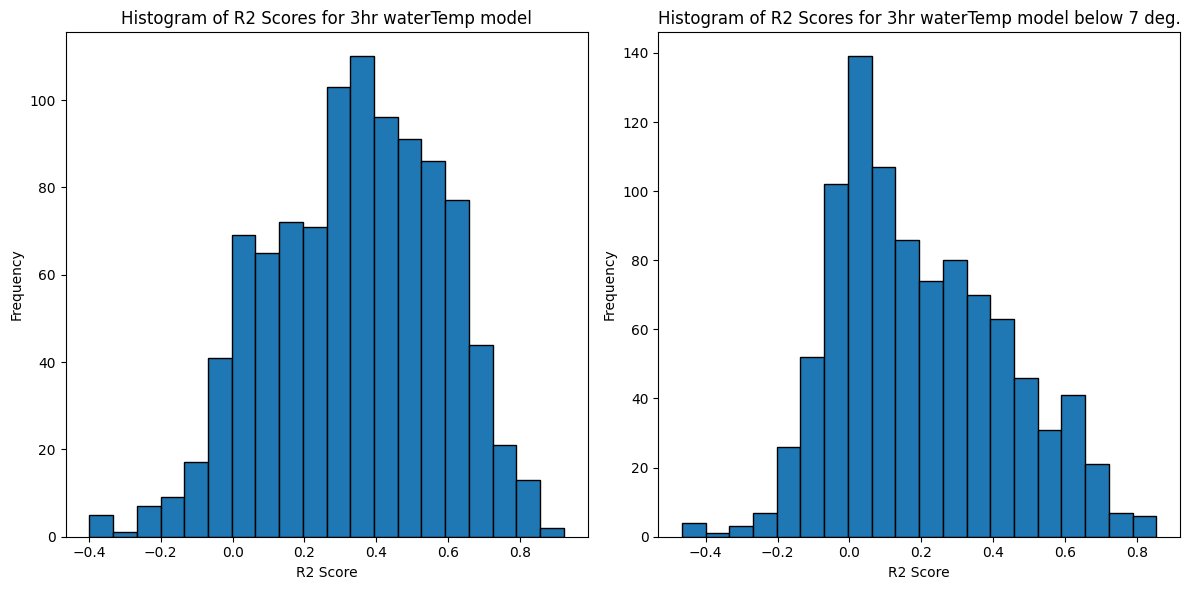

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df_cic_models['WaterTemp_3hr_R2'], bins=20, edgecolor='black')
axs[0].set_xlabel('R2 Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of R2 Scores for 3hr waterTemp model')

axs[1].hist(df_cic_models['WaterTemp_3hr_filt_R2'], bins=20, edgecolor='black')
axs[1].set_xlabel('R2 Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of R2 Scores for 3hr waterTemp model below 7 deg.')

plt.tight_layout()
plt.show()


(array([  1.,   0.,   0.,   2.,   0.,   0.,   4.,   9.,  22.,  88., 294.,
        392., 470., 556., 675., 664., 568., 380., 154.,  32.]),
 array([-1.08964432, -0.98907877, -0.88851323, -0.78794769, -0.68738214,
        -0.5868166 , -0.48625106, -0.38568552, -0.28511997, -0.18455443,
        -0.08398889,  0.01657666,  0.1171422 ,  0.21770774,  0.31827328,
         0.41883883,  0.51940437,  0.61996991,  0.72053546,  0.821101  ,
         0.92166654]),
 <BarContainer object of 20 artists>)

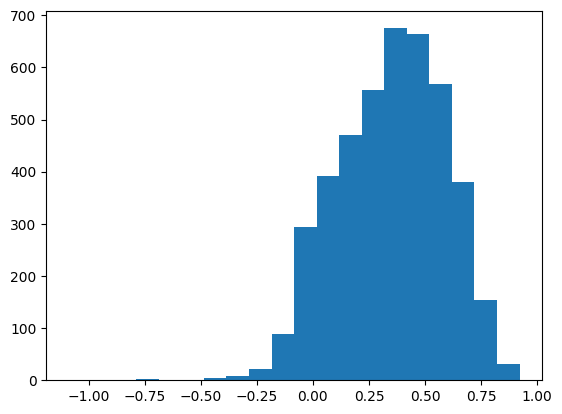

In [248]:
plt.hist(df_cic_models['WaterTemp_3hr_R2'], bins=20)

In [227]:
mean_R2_by_id = df_merged.groupby('3duo_id')[['WaterTemp_3hr_R2', 'Q_house_3hr_R2', 'WaterTemp_24hr_R2', 'Q_house_24hr_R2']].median()
print(mean_R2_by_id)

         WaterTemp_3hr_R2  Q_house_3hr_R2  WaterTemp_24hr_R2  Q_house_24hr_R2
3duo_id                                                                      
1.0              0.224591        0.368892           0.229165         0.621169
3.0              0.330692        0.470092           0.350018         0.662503
4.0              0.378360        0.505955           0.359099         0.673412
11.0             0.337149        0.468504           0.335396         0.638331
12.0             0.431072        0.533334           0.423034         0.675154


In [260]:
mean_R2_by_id = df_merged.groupby('3duo_id')[['WaterTemp_3hr_R2', 'Q_house_3hr_R2', 'WaterTemp_24hr_R2', 'Q_house_24hr_R2']].mean()
print(mean_R2_by_id)

         WaterTemp_3hr_R2  Q_house_3hr_R2  WaterTemp_24hr_R2  Q_house_24hr_R2
3duo_id                                                                      
1.0              0.247840        0.355508           0.262356         0.577986
3.0              0.328590        0.453510           0.340115         0.626800
4.0              0.343744        0.478799           0.341458         0.634452
11.0             0.329728        0.461659           0.330177         0.611364
12.0             0.418465        0.510933           0.405764         0.640544


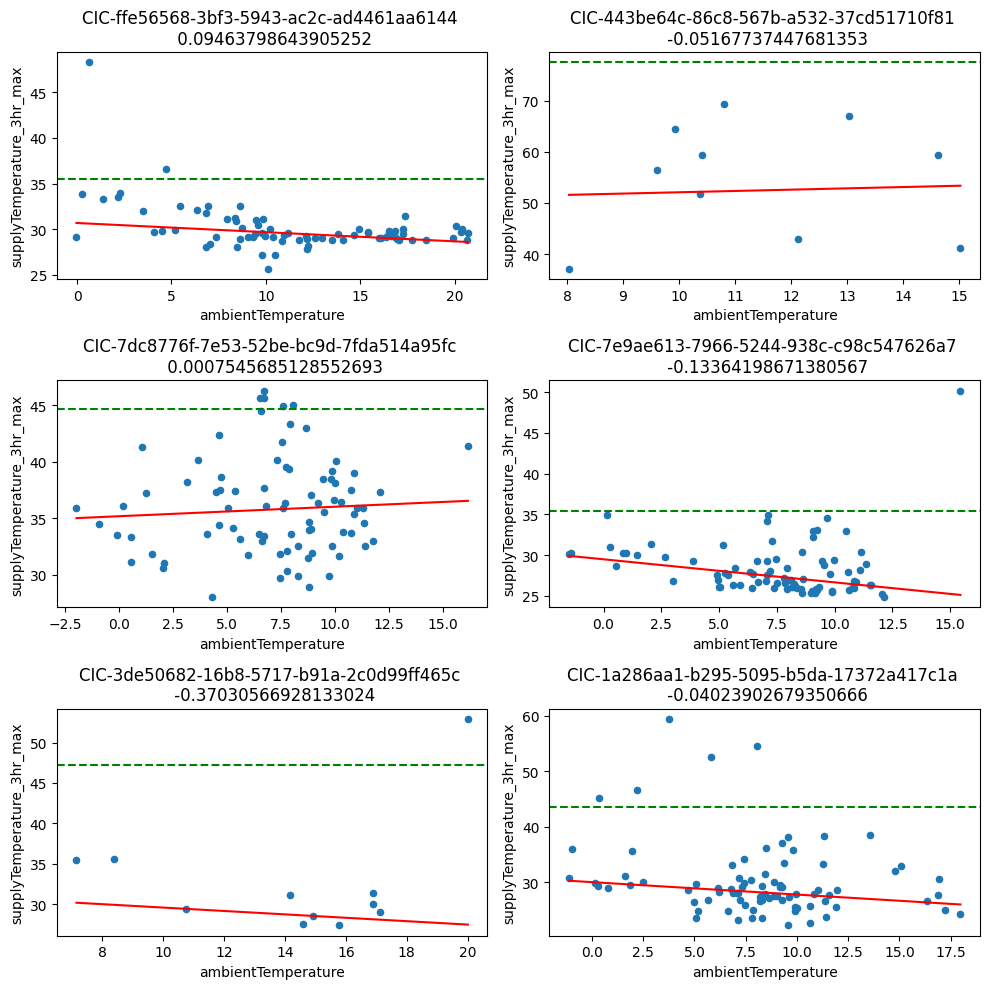

In [250]:
cics = df_merged[(df_merged['WaterTemp_3hr_R2']<0.1) &
                 (df_merged['3single_id']==1)
                 ]['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max', ax=axs[i], label=cic)
    axs[i].set_title(f"{cic} \n {df_cic_models[df_cic_models['cic_id'] == cic]['WaterTemp_3hr_R2'].values[0]}")
    axs[i].get_legend().remove()
    # add line based on linear regression model
    x = np.linspace(df_cic['ambientTemperature'].min(), df_cic['ambientTemperature'].max(), 100)
    y = df_cic_models[df_cic_models['cic_id'] == cic]['WaterTemp_3hr_slope'].values[0] * x + df_cic_models[df_cic_models['cic_id'] == cic]['WaterTemp_3hr_intercept'].values[0]
    axs[i].plot(x, y, '-r')
    # horizontal line
    axs[i].axhline(y=df_cic['supplyTemperature_3hr_max'].mean() + 2 * df_cic['supplyTemperature_3hr_max'].std(),
                   color='green', linestyle='--')
    

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()

array([[<Axes: xlabel='WaterTemp_3hr', ylabel='WaterTemp_3hr'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='WaterTemp_3hr'>,
        <Axes: xlabel='Q_house_3hr', ylabel='WaterTemp_3hr'>,
        <Axes: xlabel='Q_house_3hr_R2', ylabel='WaterTemp_3hr'>],
       [<Axes: xlabel='WaterTemp_3hr', ylabel='WaterTemp_3hr_R2'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='WaterTemp_3hr_R2'>,
        <Axes: xlabel='Q_house_3hr', ylabel='WaterTemp_3hr_R2'>,
        <Axes: xlabel='Q_house_3hr_R2', ylabel='WaterTemp_3hr_R2'>],
       [<Axes: xlabel='WaterTemp_3hr', ylabel='Q_house_3hr'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='Q_house_3hr'>,
        <Axes: xlabel='Q_house_3hr', ylabel='Q_house_3hr'>,
        <Axes: xlabel='Q_house_3hr_R2', ylabel='Q_house_3hr'>],
       [<Axes: xlabel='WaterTemp_3hr', ylabel='Q_house_3hr_R2'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='Q_house_3hr_R2'>,
        <Axes: xlabel='Q_house_3hr', ylabel='Q_house_3hr_R2'>,
        <Axes: xlabel='

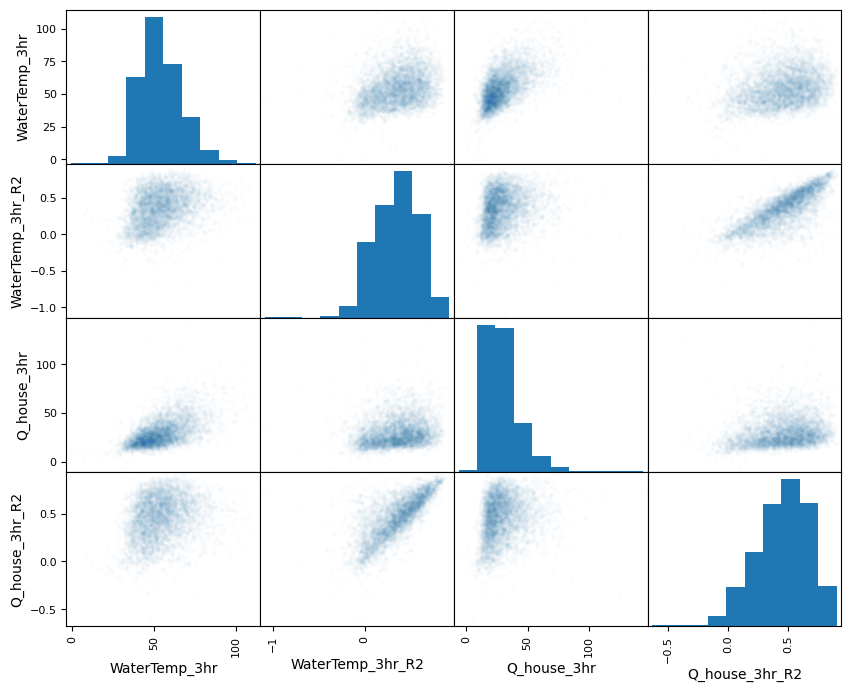

In [264]:
scatter_cols = ['WaterTemp_3hr', 'WaterTemp_3hr_R2', 'Q_house_3hr', 'Q_house_3hr_R2']
scatter_matrix(df_merged[scatter_cols], figsize=(10, 8), alpha=0.02)

# senkey diagram

{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'valuesuffix': 'TWh',
   'node': {'pad': 15,
    'thickness': 15,
    'line': {'color': 'black', 'width': 0.5},
    'label': ["Agricultural 'waste'",
     'Bio-conversion',
     'Liquid',
     'Losses',
     'Solid',
     'Gas',
     'Biofuel imports',
     'Biomass imports',
     'Coal imports',
     'Coal',
     'Coal reserves',
     'District heating',
     'Industry',
     'Heating and cooling - commercial',
     'Heating and cooling - homes',
     'Electricity grid',
     'Over generation / exports',
     'H2 conversion',
     'Road transport',
     'Agriculture',
     'Rail transport',
     'Lighting & appliances - commercial',
     'Lighting & appliances - homes',
     'Gas imports',
     'Ngas',
     'Gas reserves',
     'Thermal generation',
     'Geothermal',
     'H2',
     'Hydro',
     'International shipping',
     'Domestic aviation',
     'Internation

In [1]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()

## results
- clients right now: 8kw / 4kw
- 24hr plot (green / blue / grey) -> blue = grey i.e. (only green can switch)
- 3hr plot (green / orange / blue / grey) -> grey = cannot switch, blue = maybe / possible

- clients that have a 4kW now:
- 24hr plot (green / blue / grey) -> blue = grey i.e. (only green can switch)
- 3hr plot (green / orange / blue / grey) -> grey = cannot switch, blue = maybe / possible


- 8kW hybrid: which are in green (in both graphs): 8kW ready for upgrade
- 8kW hybrid: in green (24hr) in blue (3hr): maybe 